102
89


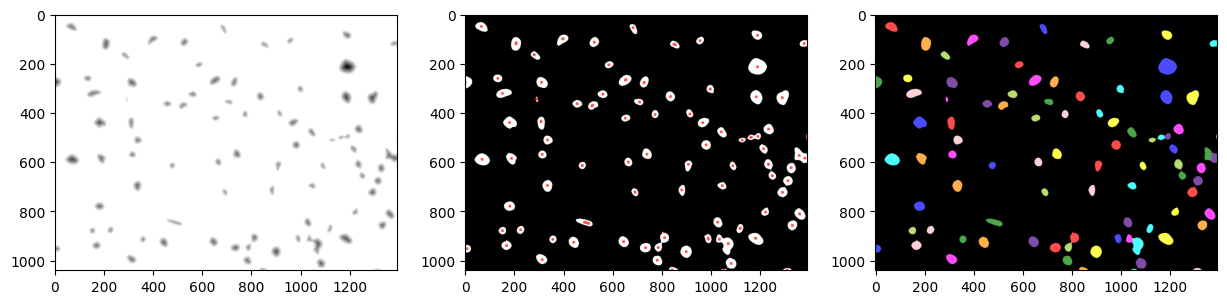

In [1]:
# Load the required libraries
import skimage as ski
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage as ndi

nuc = ski.io.imread("data/F01_202w2.TIF")
nuc_smooth = ski.filters.gaussian(nuc, sigma = 2)
nuc_binary = nuc_smooth > ski.filters.threshold_triangle(nuc_smooth)

se = ski.morphology.ellipse(5, 5)
nuc_erode = ski.morphology.binary_erosion(nuc_binary, se)

nuc_dist = -ndi.distance_transform_edt(nuc_erode)
nuc_seed = ski.morphology.h_minima(nuc_dist, h = 1)

nuc_seed_big = ski.morphology.binary_dilation(nuc_seed, se)
nuc_label_big = ski.morphology.label(nuc_seed_big)
overlay_seed = ski.color.label2rgb(
    nuc_label_big, nuc_erode, alpha=0.7, bg_label=0, bg_color=None, colors=[(1, 0, 0)]
)

nuc_label = ski.morphology.label(nuc_seed)
print(nuc_label.max())


label_img = ski.segmentation.watershed(nuc_dist, markers = nuc_label_big,  mask =  nuc_erode)
overlay = ski.color.label2rgb(
    label_img, nuc_erode, alpha=0.7, bg_color=None)
print(label_img.max())

# Plot the images
fig, ax =  plt.subplots(1, 3, figsize = (15, 5))
ax[0].imshow(nuc_dist, cmap = 'gray')
ax[1].imshow(overlay_seed)
ax[2].imshow(overlay)

89
90


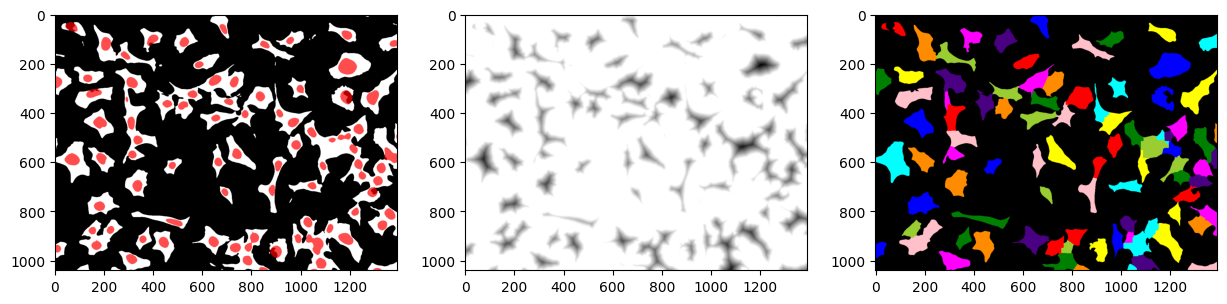

In [2]:
cyto = ski.io.imread("data/F01_202w1.TIF")
cyto_gamma = ski.exposure.adjust_gamma(cyto, 0.1)
cyto_smooth = ski.filters.gaussian(cyto_gamma, sigma = 3)


cyto_binary = cyto_smooth > ski.filters.threshold_otsu(cyto_smooth)
cyto_filled = ndi.binary_fill_holes(cyto_binary)

open_se = ski.morphology.ellipse(5, 5)
cyto_open = ski.morphology.opening(cyto_filled, open_se)

cyto_dist = -ndi.distance_transform_edt(cyto_filled)

overlay_cyto_seed = ski.color.label2rgb(
    label_img, cyto_filled, alpha=0.7, bg_label=0, bg_color=None, colors=[(1, 0, 0)]
)

cyto_label_img = ski.segmentation.watershed(cyto_dist, mask = cyto_filled, markers = label_img, compactness = 0.01)


# expanded = ski.segmentation.expand_labels(nuc_label_big, distance=100)

cyto_overlay = ski.color.label2rgb(cyto_label_img)
print(cyto_label_img.max())
print(len(np.unique(cyto_label_img)))

# Write the manipulated image to file.
ski.io.imsave('data/out.tif', cyto_label_img, check_contrast = False)

# Plot the images
fig, ax =  plt.subplots(1, 3, figsize = (15, 5))
ax[0].imshow(overlay_cyto_seed, cmap = 'gray')
ax[1].imshow(cyto_dist, cmap = 'gray')
ax[2].imshow(cyto_overlay)

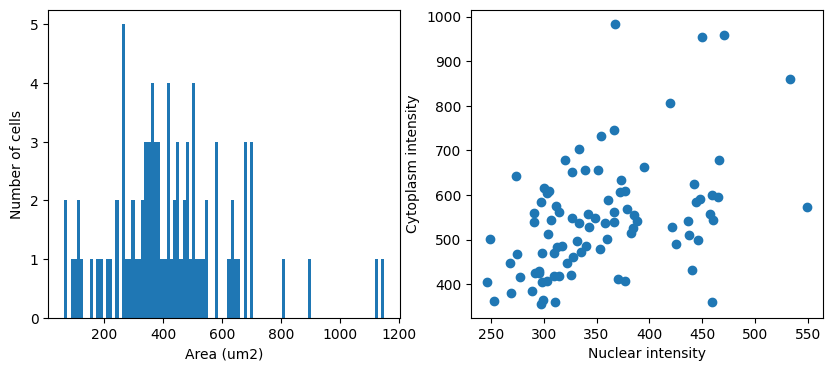

In [38]:
# the properties
cyto_features = ski.measure.regionprops(cyto_label_img, intensity_image = cyto, spacing = (0.31, 0.31))
nuc_features = ski.measure.regionprops(cyto_label_img, intensity_image = nuc, spacing = (0.31, 0.31))

cyto_area = []
nuc_intensity = []
cyto_intensity = []

for c, n in zip(cyto_features, nuc_features):
    cyto_area.append(c.area)
    cyto_intensity.append(c.intensity_mean)
    nuc_intensity.append(n.intensity_mean)

fig, ax = plt.subplots(1, 2, figsize = (10, 4))
ax[0].hist(cyto_area, bins = 100)
ax[0].set_xlabel('Area (um2)')
ax[0].set_ylabel('Number of cells')
ax[1].scatter(nuc_intensity, cyto_intensity)
ax[1].set_xlabel('Nuclear intensity')
ax[1].set_ylabel('Cytoplasm intensity')
plt.savefig('figs/cell_features.png')